# Problem statement

Happy Customer Bank is a mid-sized private bank that deals in all kinds of banking products, like Savings accounts, Current accounts, investment products, credit products and other offerings. Given the Customer details (gender, age, region etc.) and Details of  his/her relationship with the bank (Channel_Code,Vintage, 'Avg_Asset_Value etc.) of existing customers of a  Happy Customer Bank predict if any customer shows Interest towards a recommended credit card. 

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

In [2]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from xgboost import XGBClassifier

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# Read and explore the dataset

In [4]:
train_df = pd.read_csv("train_s3TEQDk.csv")
print(train_df.shape) 
train_df.info()
print('-'*30)

(245725, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB
------------------------------


In [5]:
train_df.head(5)

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [6]:
train_df['Credit_Product'].value_counts()

No     144357
Yes     72043
Name: Credit_Product, dtype: int64

In [7]:
test_df= pd.read_csv("test_mSzZ8RL.csv")
print(test_df.shape)
# test_df.fillna(-1,inplace=True)
test_df.info()

(105312, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105312 entries, 0 to 105311
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   105312 non-null  object
 1   Gender               105312 non-null  object
 2   Age                  105312 non-null  int64 
 3   Region_Code          105312 non-null  object
 4   Occupation           105312 non-null  object
 5   Channel_Code         105312 non-null  object
 6   Vintage              105312 non-null  int64 
 7   Credit_Product       92790 non-null   object
 8   Avg_Account_Balance  105312 non-null  int64 
 9   Is_Active            105312 non-null  object
dtypes: int64(3), object(7)
memory usage: 8.0+ MB


In [9]:
sample_df=pd.read_csv('sample_submission_eyYijxG.csv')
sample_df.head(5)

,ID,Is_Lead
0,VBENBARO,0
1,CCMEWNKY,0
2,VK3KGA9M,0
3,TT8RPZVC,0
4,SHQZEYTZ,0


<Figure size 432x288 with 0 Axes>

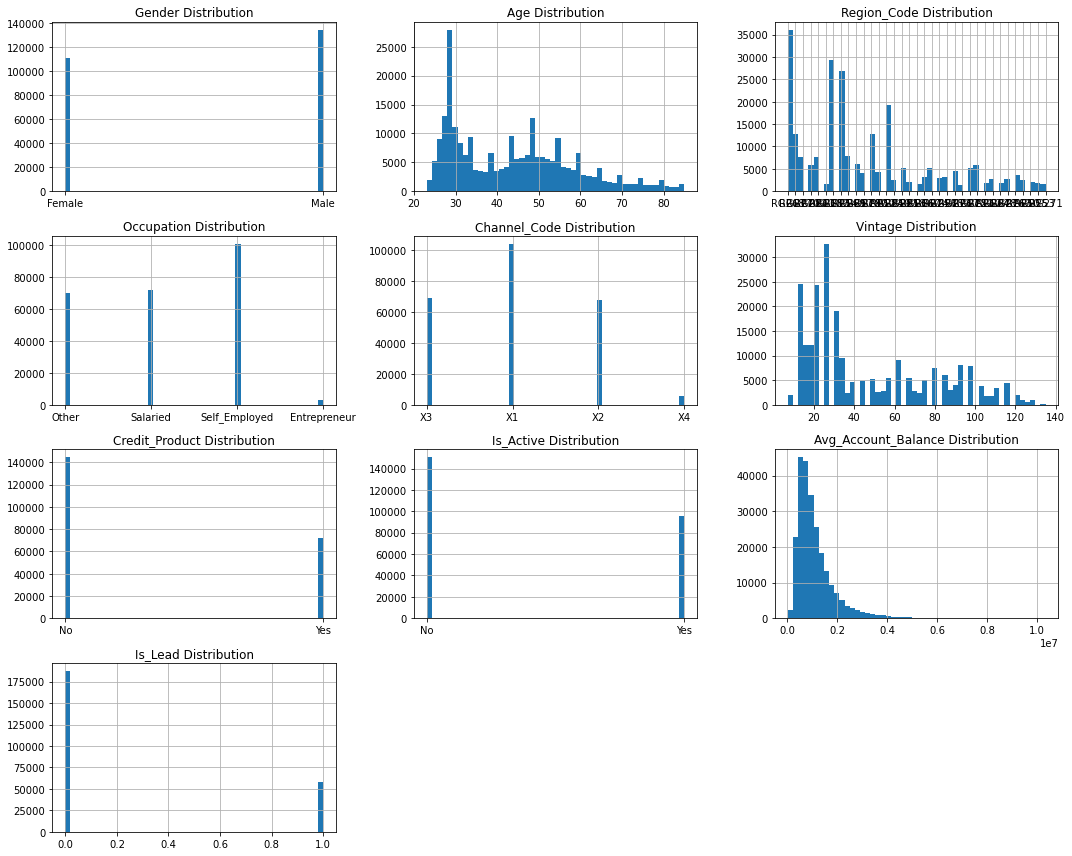

In [10]:
c_columns=['Gender','Age','Region_Code','Occupation','Channel_Code','Vintage','Credit_Product','Is_Active','Avg_Account_Balance','Is_Lead']
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure()
    fig = plt.figure(figsize=(15,12))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=50,ax=ax)
        ax.set_title(var_name+" Distribution")
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

draw_histograms(train_df,c_columns, 4, 3)

In [11]:
cat_columns=['Gender','Age_bin','Region_Code','Occupation','Channel_Code','Credit_Product','Is_Active','Vintage_bin']
num_columns=['Vintage','Avg_Account_Balance']

# Feature Engineering and preprocessing

##  1) Imputing Null values

In [12]:
nan_columns=[i for i in train_df.columns if train_df[i].isnull().any()]
nan_columns

['Credit_Product']

In [13]:
def nan_values(df,feature):
    nan_rows = df[df[feature].isnull()]
    return nan_rows,len(nan_rows)

In [14]:
for i in nan_columns:
    print(i)
    nan_rows,len_nan_rows=nan_values(train_df,i)
    print(len_nan_rows,'-'*5,len_nan_rows/train_df.shape[0])
    nan_rows1,len_nan_rows1=nan_values(test_df,i)
    print(len_nan_rows1,'-'*5,len_nan_rows1/test_df.shape[0])
    print('_'*20)

Credit_Product
29325 ----- 0.11934072642181301
12522 ----- 0.11890382862351868
____________________


Only one one column has null values and it is 11-12 percentage of total column values.

In [15]:
#fill null values with nan
train_df.fillna('nan',inplace=True)
test_df.fillna('nan',inplace=True)

## 2) Explortory data analysis

### 2.1)Explore null values with respect to output column 

In [16]:
lead_dict=dict(train_df['Is_Lead'].value_counts())
lead_0_dict=dict(train_df['Credit_Product'][train_df['Is_Lead']==0].value_counts())#credict_product values wth lead == 0
lead_1_dict=dict(train_df['Credit_Product'][train_df['Is_Lead']==1].value_counts())#credict_product values wth lead == 1

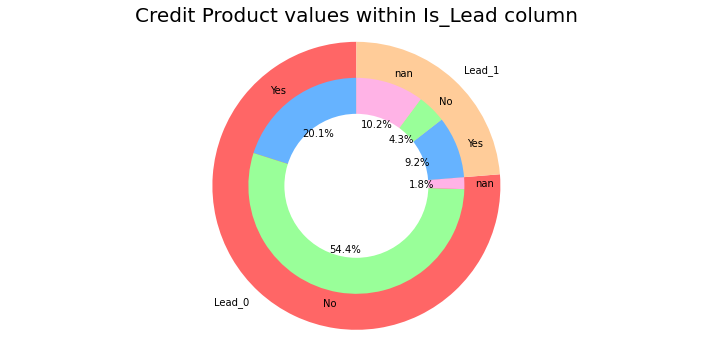

In [17]:
#plot the nested pie chart
fig = plt.figure(figsize=(10,5)) 
labels = ['Lead_0','Lead_1']
sizes =  [lead_dict[0],lead_dict[1]]
labels_gender = ['Yes','No','nan','Yes','No','nan']
sizes_gender =  [lead_0_dict['Yes'],lead_0_dict['No'],lead_0_dict['nan'],lead_1_dict['Yes'],lead_1_dict['No'],lead_1_dict['nan']]
colors = ['#ff6666', '#ffcc99']
colors_gender = ['#66b3ff','#99ff99','#ffb3e6','#66b3ff','#99ff99','#ffb3e6']
explode = (0.2,0.2) 
explode_gender = (0.1,0.1,0.1,0.1,0.1,0.1)
# Plot
plt.pie(sizes, labels=labels, colors=colors,startangle=90,frame=True,)
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,radius=0.75,startangle=90,autopct='%1.1f%%')
centre_circle = plt.Circle((0,0),0.5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Credit Product values within Is_Lead column',fontdict={'fontsize':20})
plt.axis('equal')
 
plt.tight_layout()
plt.show()

#### Observation and conclusion

Lead_0 is 76% of the data but has only 1.8% nan values and Lead_1 is 24% of the data but has 10.2% of nan values.
<br>Lead_1 alone contains 85% of nan values being only 24% of the data.
<br>Since 85% of nan values are present only in Lead_1 make a column is_null.

In [18]:
print('Percentage of nan values in lead_0 : ',lead_0_dict['nan']/(lead_1_dict['nan']+lead_0_dict['nan']))
print('Percentage of nan values in lead_1 : ',lead_1_dict['nan']/(lead_1_dict['nan']+lead_0_dict['nan']))

Percentage of nan values in lead_0 :  0.1483375959079284
Percentage of nan values in lead_1 :  0.8516624040920716


In [19]:
def is_null(credit_product):
    if credit_product == 'nan':
        return 1
    else:
        return 0
train_df['is_null']=train_df['Credit_Product'].apply(is_null)
test_df['is_null']=test_df['Credit_Product'].apply(is_null)

### 2.2)boxplot of the occupation vs vintage

<AxesSubplot:xlabel='Occupation', ylabel='Vintage'>

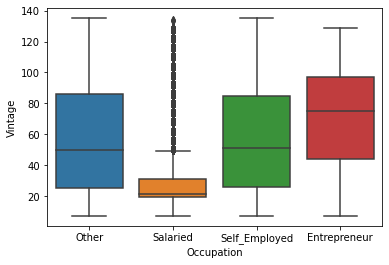

In [20]:
sns.boxplot('Occupation',num_columns[0], data=train_df)

#### Observation and conclusion
Salaried has much more outliers compared to ther Occupation 
<br> Create a new feature is_salaried

In [21]:
def is_salaried(occupation):
    if occupation == 'Salaried':
        return 1
    else:
        return 0
train_df['is_Salaried']=train_df['Occupation'].apply(is_salaried)
test_df['is_Salaried']=test_df['Occupation'].apply(is_salaried)

### 2.3)boxplot of  channel_code vs vintage

<AxesSubplot:xlabel='Channel_Code', ylabel='Vintage'>

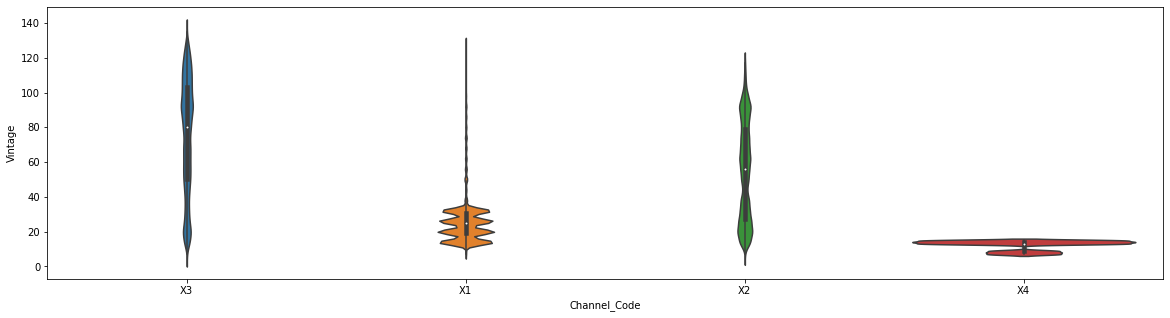

In [22]:
fig = plt.figure(figsize=(20,5))
sns.violinplot('Channel_Code',num_columns[0], data=train_df)

#### Observation and conclusion
Channel_codes X1 and X4 have very small Interquartile range compared to other plots.
<br>Create features is_X1 and is_X4 

In [23]:
def is_x1(code):
    if code == 'X1':
        return 1
    else:
        return 0
train_df['is_X1']=train_df['Channel_Code'].apply(is_x1)
test_df['is_X1']=test_df['Channel_Code'].apply(is_x1)

In [24]:
def is_x4(code):
    if code == 'X4':
        return 1
    else:
        return 0
train_df['is_X4']=train_df['Channel_Code'].apply(is_x4)
test_df['is_X4']=test_df['Channel_Code'].apply(is_x4)

## 3) Feature Binning

### 3.1)Create Vintage_bin by clubbing in the groups of 10

In [25]:
#0-9 as 0,10-19 as 1,20-29 as 2 .....
dv=dict(train_df['Vintage'].value_counts())

vintage_le={}
for i in dv.keys():
    vintage_le[i]=i//10

train_df['Vintage_bin'] = train_df['Vintage'].apply(lambda x: vintage_le[x])
test_df['Vintage_bin'] = test_df['Vintage'].apply(lambda x: vintage_le[x])

### 3.2)Create Age_bin by clubbing in the groups of 10

In [26]:
#0-9 as 0,10-19 as 1,20-29 as 2 .....90-99 as 9 
da=dict(train_df['Age'].value_counts())

age_le={}
for i in da.keys():
    age_le[i]=i//10

train_df['Age_bin'] = train_df['Age'].apply(lambda x: age_le[x])
test_df['Age_bin'] = test_df['Age'].apply(lambda x: age_le[x])

## 4) Polynomial features

### 4.1)Create feature by dividing Avg_Account_Balance with Vintage

In [27]:
train_df['Balance/Vintage']=train_df['Avg_Account_Balance']/train_df['Vintage']
test_df['Balance/Vintage']=test_df['Avg_Account_Balance']/test_df['Vintage']

### 4.2)Create feature by Multiplying Avg_Account_Balance with Vintage

In [28]:
train_df['Balance*Vintage']=train_df['Avg_Account_Balance']*train_df['Vintage']
test_df['Balance*Vintage']=test_df['Avg_Account_Balance']*test_df['Vintage']

## 5) Label Encode all the columns

In [29]:
gender_le={'Male':1,'Female':0}
occupation_le={'Self_Employed':0,'Salaried':1,'Other':2,'Entrepreneur':3}
channel_code_le={'X1':1,'X2':2,'X3':3,'X4':4}
credict_product_le={'Yes':1,'No':0,'nan':-1}
is_active_le={'Yes':1,'No':0}

In [30]:
train_df['Gender'] = train_df['Gender'].apply(lambda x: gender_le[x])
test_df['Gender'] = test_df['Gender'].apply(lambda x: gender_le[x])

train_df['Occupation'] = train_df['Occupation'].apply(lambda x: occupation_le[x])
test_df['Occupation'] = test_df['Occupation'].apply(lambda x: occupation_le[x])

train_df['Channel_Code'] = train_df['Channel_Code'].apply(lambda x: channel_code_le[x])
test_df['Channel_Code'] = test_df['Channel_Code'].apply(lambda x: channel_code_le[x])

train_df['Credit_Product'] = train_df['Credit_Product'].apply(lambda x: credict_product_le[x])
test_df['Credit_Product'] = test_df['Credit_Product'].apply(lambda x: credict_product_le[x])

train_df['Is_Active'] = train_df['Is_Active'].apply(lambda x: is_active_le[x])
test_df['Is_Active'] = test_df['Is_Active'].apply(lambda x: is_active_le[x])

In [31]:
le=LabelEncoder()
le.fit(train_df['Region_Code'])
train_df['Region_Code'] = le.fit_transform(train_df['Region_Code'])
test_df['Region_Code']  =  le.fit_transform(test_df['Region_Code'])

## 6) Create features by combining two categorical values

In [33]:
cat_columns_c=['Gender','Age_bin','Region_Code','Occupation','Channel_Code','Credit_Product','Is_Active','Vintage_bin']

comb=combinations(cat_columns_c,2)
combined_cols2=[]
for i in comb:
    train_df[i[0]+'_'+i[1]]= train_df[i[0]].astype(str)+'_'+train_df[i[1]].astype(str)
    test_df[i[0]+'_'+i[1]]= test_df[i[0]].astype(str)+'_'+test_df[i[1]].astype(str)
    combined_cols2.append(i[0]+'_'+i[1])

#### Label Encode combined features

In [34]:
le=LabelEncoder()
train_df[combined_cols2] = train_df[combined_cols2].apply(le.fit_transform)
test_df[combined_cols2] = test_df[combined_cols2].apply(le.fit_transform)

## 7) Create features by Grouping and aggregating   

#### Create features by Grouping with categorical column and then aggregating with different columns using different functions 

In [35]:
cat_columns_agg=['Gender','Age_bin','Region_Code','Occupation','Channel_Code','Is_Active','Vintage_bin']

def percentile_25(x):
    return x.quantile(0.25) #25 th percentile
def percentile_75(x):
    return x.quantile(0.75) #75 th percentile

d={}
for i in num_columns: #functions for aggregating
    d[i]=['mean', 'max','min','std',percentile_25,percentile_75] # for numerical columns
for i in cat_columns:
    d[i]=['count','nunique'] # for categorical columns
    
aggregate_features_1=[]
for i in cat_columns_agg: 
    print(i)
    print('*'*10)
    d_agg=d.copy()
#     del d_agg[i]
    agg_features = train_df.groupby([i]).agg(d_agg)
    agg_features.columns = [i+'_agg_features' + '_'.join(c).strip('_') for c in agg_features.columns] 
    aggregate_features_1.extend(agg_features.columns)
    train_df = pd.merge(train_df,agg_features, on = [i], how='left')
    test_df = pd.merge(test_df,agg_features, on = [i], how='left')

Gender
**********
Age_bin
**********
Region_Code
**********
Occupation
**********
Channel_Code
**********
Is_Active
**********
Vintage_bin
**********


#### Remove Highly correlated columns

In [36]:
corr_matrix = train_df[aggregate_features_1].corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.90
to_drop_1 = [column for column in upper.columns if any(upper[column] > 0.90)]

len(to_drop_1)

109

## 8) Frequency encoding of categorical columns

In [37]:
corr_matrix = train_df[aggregate_features_1].corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.90
to_drop_1 = [column for column in upper.columns if any(upper[column] > 0.90)]

len(to_drop_1)

109

In [38]:
def frequency_encoding(column_name,output_column_name,df1,df2):
    fe_pol = (df1.groupby(column_name).size()) / len(df1)
    df2[output_column_name] = df2[column_name].apply(lambda x : fe_pol[x])

In [39]:
for i in cat_columns:
    frequency_encoding(i,i+'_Ren',train_df,train_df)
    frequency_encoding(i,i+'_Ren',train_df,test_df)
    print(i)

Gender
Age_bin
Region_Code
Occupation
Channel_Code
Credit_Product
Is_Active
Vintage_bin


## 9) Remove Null columns

In [40]:
#Remove any columns that have null values 
remove_columns=[]
for i in train_df.columns:
    if train_df[i].isna().any():
        remove_columns.append(i)
        print(i)

In [41]:
train_df.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,is_null,is_Salaried,is_X1,is_X4,Vintage_bin,Age_bin,Balance/Vintage,Balance*Vintage,Gender_Age_bin,Gender_Region_Code,Gender_Occupation,Gender_Channel_Code,Gender_Credit_Product,Gender_Is_Active,Gender_Vintage_bin,Age_bin_Region_Code,Age_bin_Occupation,Age_bin_Channel_Code,Age_bin_Credit_Product,Age_bin_Is_Active,Age_bin_Vintage_bin,Region_Code_Occupation,Region_Code_Channel_Code,Region_Code_Credit_Product,Region_Code_Is_Active,Region_Code_Vintage_bin,Occupation_Channel_Code,Occupation_Credit_Product,Occupation_Is_Active,Occupation_Vintage_bin,Channel_Code_Credit_Product,Channel_Code_Is_Active,Channel_Code_Vintage_bin,Credit_Product_Is_Active,Credit_Product_Vintage_bin,Is_Active_Vintage_bin,Gender_agg_featuresVintage_mean,Gender_agg_featuresVintage_max,Gender_agg_featuresVintage_min,Gender_agg_featuresVintage_std,Gender_agg_featuresVintage_percentile_25,Gender_agg_featuresVintage_percentile_75,Gender_agg_featuresAvg_Account_Balance_mean,Gender_agg_featuresAvg_Account_Balance_max,Gender_agg_featuresAvg_Account_Balance_min,Gender_agg_featuresAvg_Account_Balance_std,Gender_agg_featuresAvg_Account_Balance_percentile_25,Gender_agg_featuresAvg_Account_Balance_percentile_75,Gender_agg_featuresGender_count,Gender_agg_featuresGender_nunique,Gender_agg_featuresAge_bin_count,Gender_agg_featuresAge_bin_nunique,Gender_agg_featuresRegion_Code_count,Gender_agg_featuresRegion_Code_nunique,Gender_agg_featuresOccupation_count,Gender_agg_featuresOccupation_nunique,Gender_agg_featuresChannel_Code_count,Gender_agg_featuresChannel_Code_nunique,Gender_agg_featuresCredit_Product_count,Gender_agg_featuresCredit_Product_nunique,Gender_agg_featuresIs_Active_count,Gender_agg_featuresIs_Active_nunique,Gender_agg_featuresVintage_bin_count,Gender_agg_featuresVintage_bin_nunique,Age_bin_agg_featuresVintage_mean,Age_bin_agg_featuresVintage_max,Age_bin_agg_featuresVintage_min,Age_bin_agg_featuresVintage_std,Age_bin_agg_featuresVintage_percentile_25,Age_bin_agg_featuresVintage_percentile_75,Age_bin_agg_featuresAvg_Account_Balance_mean,Age_bin_agg_featuresAvg_Account_Balance_max,Age_bin_agg_featuresAvg_Account_Balance_min,Age_bin_agg_featuresAvg_Account_Balance_std,Age_bin_agg_featuresAvg_Account_Balance_percentile_25,Age_bin_agg_featuresAvg_Account_Balance_percentile_75,Age_bin_agg_featuresGender_count,Age_bin_agg_featuresGender_nunique,Age_bin_agg_featuresAge_bin_count,Age_bin_agg_featuresAge_bin_nunique,Age_bin_agg_featuresRegion_Code_count,Age_bin_agg_featuresRegion_Code_nunique,Age_bin_agg_featuresOccupation_count,Age_bin_agg_featuresOccupation_nunique,Age_bin_agg_featuresChannel_Code_count,Age_bin_agg_featuresChannel_Code_nunique,Age_bin_agg_featuresCredit_Product_count,Age_bin_agg_featuresCredit_Product_nunique,Age_bin_agg_featuresIs_Active_count,...,Occupation_agg_featuresChannel_Code_count,Occupation_agg_featuresChannel_Code_nunique,Occupation_agg_featuresCredit_Product_count,Occupation_agg_featuresCredit_Product_nunique,Occupation_agg_featuresIs_Active_count,Occupation_agg_featuresIs_Active_nunique,Occupation_agg_featuresVintage_bin_count,Occupation_agg_featuresVintage_bin_nunique,Channel_Code_agg_featuresVintage_mean,Channel_Code_agg_featuresVintage_max,Channel_Code_agg_featuresVintage_min,Channel_Code_agg_featuresVintage_std,Channel_Code_agg_featuresVintage_percentile_25,Channel_Code_agg_featuresVintage_percentile_75,Channel_Code_agg_featuresAvg_Account_Balance_mean,Channel_Code_agg_featuresAvg_Account_Balance_max,Channel_Code_agg_featuresAvg_Account_Balance_min,Channel_Code_agg_featuresAvg_Account_Balance_std,Channel_Code_agg_featuresAvg_Account_Balance_percentile_25,Channel_Code_agg_featuresAvg_Account_Balance_percentile_75,Channel_Code_agg_featuresGender_count,Channel_Code_agg_featuresGender_nunique,Channel_Code_agg_featuresAge_bin_count,Channel_Code_agg_featuresAge_bin_nunique,Channel_Code_agg_featuresRegion_Code_count,Channel_Code_agg_

In [42]:
test_df.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,is_null,is_Salaried,is_X1,is_X4,Vintage_bin,Age_bin,Balance/Vintage,Balance*Vintage,Gender_Age_bin,Gender_Region_Code,Gender_Occupation,Gender_Channel_Code,Gender_Credit_Product,Gender_Is_Active,Gender_Vintage_bin,Age_bin_Region_Code,Age_bin_Occupation,Age_bin_Channel_Code,Age_bin_Credit_Product,Age_bin_Is_Active,Age_bin_Vintage_bin,Region_Code_Occupation,Region_Code_Channel_Code,Region_Code_Credit_Product,Region_Code_Is_Active,Region_Code_Vintage_bin,Occupation_Channel_Code,Occupation_Credit_Product,Occupation_Is_Active,Occupation_Vintage_bin,Channel_Code_Credit_Product,Channel_Code_Is_Active,Channel_Code_Vintage_bin,Credit_Product_Is_Active,Credit_Product_Vintage_bin,Is_Active_Vintage_bin,Gender_agg_featuresVintage_mean,Gender_agg_featuresVintage_max,Gender_agg_featuresVintage_min,Gender_agg_featuresVintage_std,Gender_agg_featuresVintage_percentile_25,Gender_agg_featuresVintage_percentile_75,Gender_agg_featuresAvg_Account_Balance_mean,Gender_agg_featuresAvg_Account_Balance_max,Gender_agg_featuresAvg_Account_Balance_min,Gender_agg_featuresAvg_Account_Balance_std,Gender_agg_featuresAvg_Account_Balance_percentile_25,Gender_agg_featuresAvg_Account_Balance_percentile_75,Gender_agg_featuresGender_count,Gender_agg_featuresGender_nunique,Gender_agg_featuresAge_bin_count,Gender_agg_featuresAge_bin_nunique,Gender_agg_featuresRegion_Code_count,Gender_agg_featuresRegion_Code_nunique,Gender_agg_featuresOccupation_count,Gender_agg_featuresOccupation_nunique,Gender_agg_featuresChannel_Code_count,Gender_agg_featuresChannel_Code_nunique,Gender_agg_featuresCredit_Product_count,Gender_agg_featuresCredit_Product_nunique,Gender_agg_featuresIs_Active_count,Gender_agg_featuresIs_Active_nunique,Gender_agg_featuresVintage_bin_count,Gender_agg_featuresVintage_bin_nunique,Age_bin_agg_featuresVintage_mean,Age_bin_agg_featuresVintage_max,Age_bin_agg_featuresVintage_min,Age_bin_agg_featuresVintage_std,Age_bin_agg_featuresVintage_percentile_25,Age_bin_agg_featuresVintage_percentile_75,Age_bin_agg_featuresAvg_Account_Balance_mean,Age_bin_agg_featuresAvg_Account_Balance_max,Age_bin_agg_featuresAvg_Account_Balance_min,Age_bin_agg_featuresAvg_Account_Balance_std,Age_bin_agg_featuresAvg_Account_Balance_percentile_25,Age_bin_agg_featuresAvg_Account_Balance_percentile_75,Age_bin_agg_featuresGender_count,Age_bin_agg_featuresGender_nunique,Age_bin_agg_featuresAge_bin_count,Age_bin_agg_featuresAge_bin_nunique,Age_bin_agg_featuresRegion_Code_count,Age_bin_agg_featuresRegion_Code_nunique,Age_bin_agg_featuresOccupation_count,Age_bin_agg_featuresOccupation_nunique,Age_bin_agg_featuresChannel_Code_count,Age_bin_agg_featuresChannel_Code_nunique,Age_bin_agg_featuresCredit_Product_count,Age_bin_agg_featuresCredit_Product_nunique,Age_bin_agg_featuresIs_Active_count,Age_bin_agg_featuresIs_Active_nunique,...,Occupation_agg_featuresChannel_Code_count,Occupation_agg_featuresChannel_Code_nunique,Occupation_agg_featuresCredit_Product_count,Occupation_agg_featuresCredit_Product_nunique,Occupation_agg_featuresIs_Active_count,Occupation_agg_featuresIs_Active_nunique,Occupation_agg_featuresVintage_bin_count,Occupation_agg_featuresVintage_bin_nunique,Channel_Code_agg_featuresVintage_mean,Channel_Code_agg_featuresVintage_max,Channel_Code_agg_featuresVintage_min,Channel_Code_agg_featuresVintage_std,Channel_Code_agg_featuresVintage_percentile_25,Channel_Code_agg_featuresVintage_percentile_75,Channel_Code_agg_featuresAvg_Account_Balance_mean,Channel_Code_agg_featuresAvg_Account_Balance_max,Channel_Code_agg_featuresAvg_Account_Balance_min,Channel_Code_agg_featuresAvg_Account_Balance_std,Channel_Code_agg_featuresAvg_Account_Balance_percentile_25,Channel_Code_agg_featuresAvg_Account_Balance_percentile_75,Channel_Code_agg_featuresGender_count,Channel_Code_agg_featuresGender_nunique,Channel_Code_agg_featuresAge_bin_count,Channel_Code_agg_featuresAge_bin_nunique,Channel_Code_agg_featuresRegio

# Building the models
### Here we are building two different models with same set of inputs.

## XGBClassifier

In [43]:
y=train_df['Is_Lead']
X_1=train_df.drop(['ID','Is_Lead'],axis=1)
X_test_1=test_df.drop(['ID'],axis=1)

for i in cat_columns:
    X_1=X_1.drop([i],axis=1)
    X_test_1=X_test_1.drop([i],axis=1)
for i in to_drop_1:
    X_1=X_1.drop([i],axis=1)
    X_test_1=X_test_1.drop([i],axis=1)
for i in remove_columns:
    try :
        X_1=X_1.drop([i],axis=1)
        X_test_1=X_test_1.drop([i],axis=1)
    except KeyError:
        continue

In [44]:
print(X_1.shape)
X_1.head()

(245725, 132)


,Age,Vintage,Avg_Account_Balance,is_null,is_Salaried,is_X1,is_X4,Balance/Vintage,Balance*Vintage,Gender_Age_bin,Gender_Region_Code,Gender_Occupation,Gender_Channel_Code,Gender_Credit_Product,Gender_Is_Active,Gender_Vintage_bin,Age_bin_Region_Code,Age_bin_Occupation,Age_bin_Channel_Code,Age_bin_Credit_Product,Age_bin_Is_Active,Age_bin_Vintage_bin,Region_Code_Occupation,Region_Code_Channel_Code,Region_Code_Credit_Product,Region_Code_Is_Active,Region_Code_Vintage_bin,Occupation_Channel_Code,Occupation_Credit_Product,Occupation_Is_Active,Occupation_Vintage_bin,Channel_Code_Credit_Product,Channel_Code_Is_Active,Channel_Code_Vintage_bin,Credit_Product_Is_Active,Credit_Product_Vintage_bin,Is_Active_Vintage_bin,Gender_agg_featuresVintage_mean,Gender_agg_featuresVintage_max,Gender_agg_featuresVintage_min,Gender_agg_featuresGender_nunique,Gender_agg_featuresAge_bin_nunique,Gender_agg_featuresRegion_Code_nunique,Gender_agg_featuresOccupation_nunique,Gender_agg_featuresChannel_Code_nunique,Gender_agg_featuresCredit_Product_nunique,Gender_agg_featuresIs_Active_nunique,Gender_agg_featuresVintage_bin_nunique,Age_bin_agg_featuresVintage_mean,Age_bin_agg_featuresVintage_max,Age_bin_agg_featuresVintage_min,Age_bin_agg_featuresAvg_Account_Balance_max,Age_bin_agg_featuresAvg_Account_Balance_min,Age_bin_agg_featuresGender_nunique,Age_bin_agg_featuresAge_bin_nunique,Age_bin_agg_featuresRegion_Code_nunique,Age_bin_agg_featuresChannel_Code_nunique,Age_bin_agg_featuresCredit_Product_nunique,Age_bin_agg_featuresIs_Active_nunique,Region_Code_agg_featuresVintage_mean,Region_Code_agg_featuresVintage_max,Region_Code_agg_featuresVintage_min,Region_Code_agg_featuresAvg_Account_Balance_mean,Region_Code_agg_featuresAvg_Account_Balance_max,Region_Code_agg_featuresAvg_Account_Balance_min,Region_Code_agg_featuresGender_count,Region_Code_agg_featuresGender_nunique,Region_Code_agg_featuresAge_bin_nunique,Region_Code_agg_featuresRegion_Code_nunique,Region_Code_agg_featuresOccupation_nunique,Region_Code_agg_featuresChannel_Code_nunique,Region_Code_agg_featuresCredit_Product_nunique,Region_Code_agg_featuresIs_Active_nunique,Occupation_agg_featuresVintage_mean,Occupation_agg_featuresVintage_max,Occupation_agg_featuresVintage_min,Occupation_agg_featuresAvg_Account_Balance_mean,Occupation_agg_featuresAvg_Account_Balance_max,Occupation_agg_featuresAvg_Account_Balance_min,Occupation_agg_featuresGender_count,Occupation_agg_featuresGender_nunique,Occupation_agg_featuresAge_bin_nunique,Occupation_agg_featuresRegion_Code_nunique,Occupation_agg_featuresOccupation_nunique,Occupation_agg_featuresChannel_Code_nunique,Occupation_agg_featuresCredit_Product_nunique,Occupation_agg_featuresIs_Active_nunique,Occupation_agg_featuresVintage_bin_nunique,Channel_Code_agg_featuresVintage_mean,Channel_Code_agg_featuresVintage_max,Channel_Code_agg_featuresVintage_min,Channel_Code_agg_featuresAvg_Account_Balance_max,Channel_Code_agg_featuresAvg_Account_Balance_min,Channel_Code_agg_featuresGender_count,Channel_Code_agg_featuresGender_nunique,Channel_Code_agg_featuresAge_bin_nunique,Channel_Code_agg_featuresRegion_Code_nunique,Channel_Code_agg_featuresOccupation_nunique,Channel_Code_agg_featuresChannel_Code_nunique,Channel_Code_agg_featuresCredit_Product_nunique,Channel_Code_agg_featuresIs_Active_nunique,Channel_Code_agg_featuresVintage_bin_nunique,Is_Active_agg_featuresVintage_mean,Is_Active_agg_featuresVintage_max,Is_Active_agg_featuresVintage_min,Is_Active_agg_featuresGender_nunique,Is_Active_agg_featuresAge_bin_nunique,Is_Active_agg_featuresRegion_Code_nunique,Is_Active_agg_featuresOccupation_nunique,Is_Active_agg_featuresChannel_Code_nunique,Is_Active_agg_featuresCredit_Product_nunique,Is_Active_agg_featuresIs_Active_nunique,Is_Active_agg_featuresVintage_bin_nunique,Vintage_bin_agg_featuresVintage_mean,Vintage_bin_agg_featuresVintage_std,Vintage_bin_agg_featuresAvg_Account_Balance_max,Vintage_bin_agg_featuresAvg_Account_Balance_min,Vintage_bin_agg_featuresGender_count,Vintage_bin_agg_feature

In [45]:
xgb=XGBClassifier(colsample_bytree=0.7, max_depth=5)
xgb.fit(X_1,y)

XGBClassifier(colsample_bytree=0.7, max_depth=5)

In [46]:
p1=xgb.predict_proba(X_test_1)

In [47]:
sample_df['Is_Lead']=p1[:,1]
sample_df.to_csv('jobathon_xgb.csv',index=False) 

In [62]:
sxgb=pd.read_csv('jobathon_xgb.csv')
sxgb.head(5)

,ID,Is_Lead
0,VBENBARO,0.042605
1,CCMEWNKY,0.883305
2,VK3KGA9M,0.057068
3,TT8RPZVC,0.025127
4,SHQZEYTZ,0.022630


### XGB Model Feature Importance

In [49]:
f_importance_df = pd.DataFrame(xgb.feature_importances_, columns=['importance'], index=X_1.columns)
f_importance_df = f_importance_df.sort_values(by='importance', ascending=False)

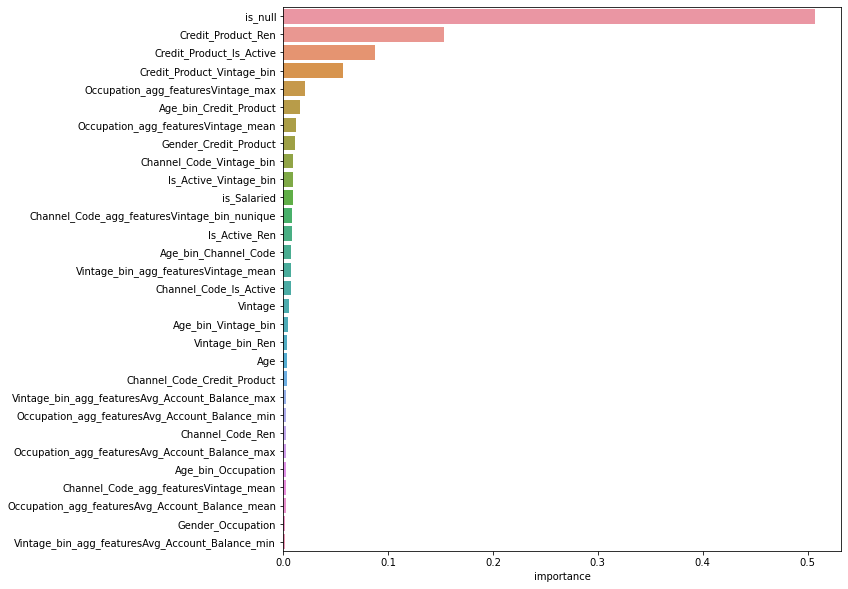

In [54]:
plt.figure(figsize=(10,10))
sns.barplot(x=f_importance_df.importance[:30], y=f_importance_df.index[:30]);

#### is_null is the most important feature which was created by analysing null values .

## CATboost Classifier

In [55]:
cat=CatBoostClassifier(silent=True,learning_rate=0.1,max_depth=3,n_estimators=750,scale_pos_weight=1)
cat.fit(X_1,y)

In [56]:
p2=cat.predict_proba(X_test_1)

In [57]:
sample_df['Is_Lead']=p2[:,1]
sample_df.to_csv('jobathon_cat.csv',index=False) 

In [61]:
scat=pd.read_csv('jobathon_cat.csv')
scat.head(5)

,ID,Is_Lead
0,VBENBARO,0.051477
1,CCMEWNKY,0.861946
2,VK3KGA9M,0.067162
3,TT8RPZVC,0.024706
4,SHQZEYTZ,0.025246


## cat Model Feature Importance

In [59]:
f_importance_df = pd.DataFrame(cat.feature_importances_, columns=['importance'], index=X_1.columns)
f_importance_df = f_importance_df.sort_values(by='importance', ascending=False)

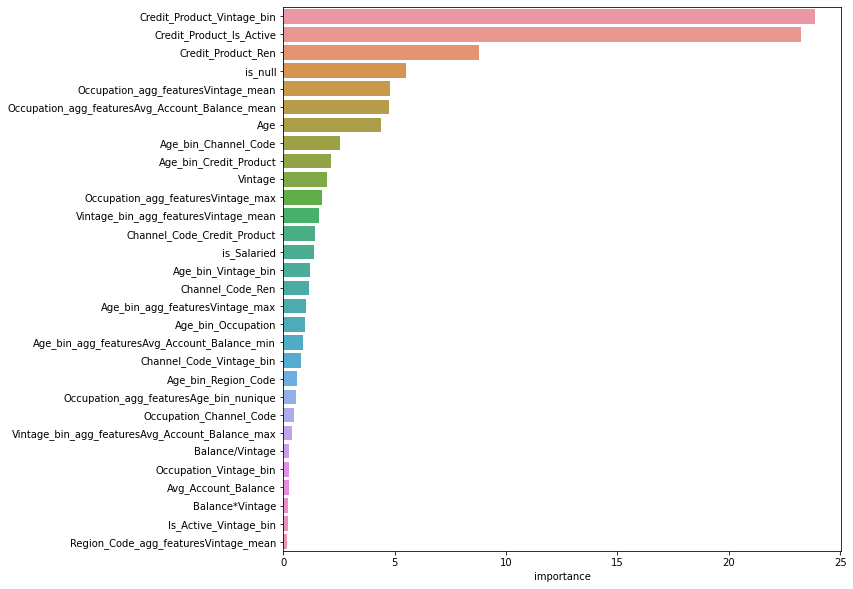

In [60]:
plt.figure(figsize=(10,10))
sns.barplot(x=f_importance_df.importance[:30], y=f_importance_df.index[:30]);

#### Credit_product_vintage_bin is the most important feature which was created by combining columns after binning.

## Final result

In [63]:
p28=0.2*p1[:,1]+0.8*p2[:,1]

In [64]:
p28

array([0.04970252, 0.86621798, 0.0651432 , ..., 0.13084131, 0.22463609,
       0.04878312])

In [65]:
sample_df['Is_Lead']=p28
sample_df.to_csv('jobathon_final.csv',index=False) 

In [66]:
sfinal=pd.read_csv('jobathon_final.csv')
sfinal.head(5)

,ID,Is_Lead
0,VBENBARO,0.049703
1,CCMEWNKY,0.866218
2,VK3KGA9M,0.065143
3,TT8RPZVC,0.024790
4,SHQZEYTZ,0.024722
